# How to Predict the Overseas Success of Domestic Films

In [64]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import os
from bs4 import BeautifulSoup
import requests
from datetime import datetime
import numpy as np
import matplotlib as plt
%matplotlib inline



In [31]:
chromedriver = "/Users/colekev/Downloads/chromedriver"
os.environ["webdriver.chrome.driver"] = chromedriver


driver = webdriver.Chrome(chromedriver)

### Scraping boxofficemojo with selenium

In [23]:
movies = {}
for i in range(2000, 2016):
    driver.get('http://www.boxofficemojo.com/yearly/chart/?yr='
                      + str(i) + '&p=.htm')

    movie_url_selector = '//a[contains(@href, "/movies/")]'

    for url in driver.find_elements_by_xpath(movie_url_selector):
        movies[url.text] = [url.get_attribute('href'), i]

In [24]:
#movies = {'Matchstick Men': ['http://www.boxofficemojo.com/movies/?id=matchstickmen.htm', 2003]}

for k,v in movies.items():
    url = v[0]
    driver.get(url)
    
    try:
        foreign_per_selector='//*[@id="body"]/table[2]/tbody/tr/td/table[2]/tbody/tr[2]/td/table/tbody/tr/td[1]/table/tbody/tr/td[1]/div[1]/div[2]/table/tbody/tr[2]/td[3]'
        foreign_per = driver.find_element_by_xpath(foreign_per_selector).text
        foreign_per = foreign_per.replace(' ', '')
        foreign_per = float(foreign_per.replace('%', ''))
    except:
        foreign_per = 'N/A'
    
    try:
        domestic_selector = '//font[contains(text(), "Domestic ")]/b'
        domestic = driver.find_element_by_xpath(domestic_selector).text
        domestic = domestic.replace(' ', '')
        domestic = domestic.replace('$', '')
        domestic = int(domestic.replace(',', ''))
    except:
        domestic = 'N/A'
    
    try:
        foreign_selector='//*[@id="body"]/table[2]/tbody/tr/td/table[2]/tbody/tr[2]/td/table/tbody/tr/td[1]/table/tbody/tr/td[1]/div[1]/div[2]/table/tbody/tr[2]/td[2]'
        foreign = driver.find_element_by_xpath(foreign_selector).text
        foreign = foreign.replace(' ', '')
        foreign = foreign.replace('$', '')
        foreign = int(foreign.replace(',', ''))
    except:
        foreign = 'N/A'
    
    try:
        budget_selector = '//td[contains(text(), "Production ")]/b'
        budget = driver.find_element_by_xpath(budget_selector).text
        budget = budget.replace(' ', '')
        budget = budget.replace('$', '')
        budget = budget.replace('million', '000000')
        budget = int(budget.replace(',', ''))
    except:
        budget = 'N/A'
    
    try:
        mpaa_selector = '//td[contains(text(), "MPAA ")]/b' 
        mpaa = driver.find_element_by_xpath(mpaa_selector).text
    except:
        mpaa = 'N/A'
        
    try:
        genre_selector = '//a[contains(@href, "/genres/chart/")]'
        genre = driver.find_elements_by_xpath(genre_selector)[0].text
    except:
        genre = 'N/A'
    
    try:
        director_selector = '//a[contains(@href, "/people/chart/?view=Director")]'
        lead_director = driver.find_elements_by_xpath(director_selector)[0].text
        lead_director_url = driver.find_elements_by_xpath(director_selector)[0].get_attribute('href')
    except:
        lead_director = 'N/A'
        lead_director_url = 'N/A'
    
    try:
        actor_selector = '//a[contains(@href, "/people/chart/?view=Actor")]'
        lead_actor = driver.find_elements_by_xpath(actor_selector)[0].text
        lead_actor_url = driver.find_elements_by_xpath(actor_selector)[0].get_attribute('href')        
    except:
        lead_actor = 'N/A'
        lead_actor_url = 'N/A'
    
    
    movies[k].extend([foreign_per, domestic, foreign, budget, mpaa, genre, 
                   lead_director, lead_director_url, lead_actor, lead_actor_url])
    

In [25]:
movies_df = pd.DataFrame.from_dict(movies, orient='index')
movies_df = movies_df.reset_index()
movies_df.columns = ['title','url','year', 'foreign_per', 'domestic_gross', 'foreign_gross',
                    'budget', 'mpaa', 'genre', 'lead_director', 'lead_director_url', 
                    'lead_actor', 'lead_actor_url']

In [32]:
dir_foreign_per_total = []

for k,v in movies.items():
    
    mov_date = v[1]

    dir_url = v[9]
    
    try:
        response=requests.get(dir_url)
    except:
        dir_foreign_per_total.append('N/A')
        continue
        
    page=response.text

    soup=BeautifulSoup(page, "lxml")
    
    tables=soup.find_all("table")
    rows=[row for row in tables[2].find_all('tr')]

    dir_movies={}
    for row in rows:
        items = row.find_all('td')
        title = items[1].text
        
         
        gross = items[3].text.replace(' ', '')
        gross = gross.replace('$', '')
        gross = gross.replace(',', '')
        gross = gross.replace('million', '000000')
        gross = gross.replace('n/a', '0')
        
        values = [items[0].text, items[1].find('a')['href'], gross]
        dir_movies[title] = values
        
        dir_movies.pop('Title (click to view)', None)
        
    
    dir_movies_df = pd.DataFrame.from_dict(dir_movies, orient='index')
    dir_movies_df = dir_movies_df.reset_index()
    dir_movies_df.columns = ['title', 'date', 'url', 'gross']
    
    #print(dir_movies_df.gross)
    dir_movies_df['gross'] = pd.to_numeric(dir_movies_df.gross)
    
    try:
        dir_movies_df['date_formatted'] = [int(datetime.strptime(i, '%m/%d/%y').strftime('%Y')) for i in dir_movies_df.date]
    except:
        dir_movies_df['date_formatted'] = 1975
        
    # find dates within last five years
    dir_movies_df = dir_movies_df[dir_movies_df.date_formatted < mov_date]
    dir_movies_df = dir_movies_df[dir_movies_df.date_formatted > mov_date - 5]
    dir_movies_df = dir_movies_df[dir_movies_df.gross > 1000000]
    
    # find the foreign% for recent movies
    dir_foreign_per = []
    for i in dir_movies_df.url:
        
        url = 'http://www.boxofficemojo.com/' + i
        driver.get(url)
        
        try:
            foreign_per_selector='//*[@id="body"]/table[2]/tbody/tr/td/table[2]/tbody/tr[2]/td/table/tbody/tr/td[1]/table/tbody/tr/td[1]/div[1]/div[2]/table/tbody/tr[2]/td[3]'
            foreign_per = driver.find_element_by_xpath(foreign_per_selector).text
            dir_foreign_per.append(foreign_per.strip())
        except:
            foreign_per = '0%'
            dir_foreign_per.append(foreign_per.strip())
    
    
    dir_foreign_per = [float(i.replace('%', '')) for i in dir_foreign_per]
    
    try:
        dir_foreign_per = sum(dir_foreign_per)/len(dir_foreign_per)
    except:
        dir_foreign_per = 'N/A'
        
    dir_foreign_per_total.append(str(dir_foreign_per))
        
movies_df['dir_foreign_per'] = dir_foreign_per_total

In [34]:
act_foreign_per_total = []

for k,v in movies.items():
    
    mov_date = v[1]

    act_url = v[11]
    
    try:
        response=requests.get(act_url)
    except:
        act_foreign_per_total.append('N/A')
        continue
        
    page=response.text

    soup=BeautifulSoup(page, "lxml")
    
    tables=soup.find_all("table")
    rows=[row for row in tables[2].find_all('tr')]

    act_movies={}
    try:
        for row in rows:
            items = row.find_all('td')
            title = items[1].text
        
         
            gross = items[3].text.replace(' ', '')
            gross = gross.replace('$', '')
            gross = gross.replace(',', '')
            gross = gross.replace('million', '000000')
            gross = gross.replace('n/a', '0')
            
            values = [items[0].text, items[1].find('a')['href'], gross]
            act_movies[title] = values
        
            act_movies.pop('Title (click to view)', None)
        
    
        act_movies_df = pd.DataFrame.from_dict(act_movies, orient='index')
        act_movies_df = act_movies_df.reset_index()
        act_movies_df.columns = ['title', 'date', 'url', 'gross']
    
        #print(dir_movies_df.gross)
        act_movies_df['gross'] = pd.to_numeric(act_movies_df.gross)
    except:
        act_foreign_per_total.append('N/A')
        continue
    
    try:
        act_movies_df['date_formatted'] = [int(datetime.strptime(i, '%m/%d/%y').strftime('%Y')) for i in act_movies_df.date]
    except:
        act_movies_df['date_formatted'] = 1975
        
    # find dates within last five years
    act_movies_df = act_movies_df[act_movies_df.date_formatted < mov_date]
    act_movies_df = act_movies_df[act_movies_df.date_formatted > mov_date - 5]
    act_movies_df = act_movies_df[act_movies_df.gross > 1000000]
    
    # find the foreign% for recent movies
    act_foreign_per = []
    for i in act_movies_df.url:
        
        url = 'http://www.boxofficemojo.com/' + i
        driver.get(url)
        
        try:
            foreign_per_selector='//*[@id="body"]/table[2]/tbody/tr/td/table[2]/tbody/tr[2]/td/table/tbody/tr/td[1]/table/tbody/tr/td[1]/div[1]/div[2]/table/tbody/tr[2]/td[3]'
            foreign_per = driver.find_element_by_xpath(foreign_per_selector).text
            act_foreign_per.append(foreign_per.strip())
        except:
            foreign_per = '0%'
            act_foreign_per.append(foreign_per.strip())
    
    
    act_foreign_per = [float(i.replace('%', '')) for i in act_foreign_per]
    
    try:
        act_foreign_per = (sum(act_foreign_per)/len(act_foreign_per))
    except:
        act_foreign_per = 'N/A'
        
    act_foreign_per_total.append(str(act_foreign_per))
        
movies_df['act_foreign_per'] = act_foreign_per_total

In [ ]:
driver.close()

In [35]:
movies_df.head()

,title,url,year,foreign_per,domestic_gross,foreign_gross,budget,mpaa,genre,lead_director,lead_director_url,lead_actor,lead_actor_url,dir_foreign_per,act_foreign_per
0,Non-Stop,http://www.boxofficemojo.com/movies/?id=nonsto...,2014,58.6,92168600,130641000,50000000,PG-13,Hostage,Jaume Collet-Serra,http://www.boxofficemojo.com/people/chart/?vie...,Liam Neeson,http://www.boxofficemojo.com/people/chart/?vie...,51.3,63.41818181818182
1,The Gambler,http://www.boxofficemojo.com/movies/?id=gamble...,2014,14.3,33680992,5600000,25000000,R,Crime Time,Rupert Wyatt,http://www.boxofficemojo.com/people/chart/?vie...,Mark Wahlberg,http://www.boxofficemojo.com/people/chart/?vie...,63.3,31.977777777777774
2,Stuck on You,http://www.boxofficemojo.com/movies/?id=stucko...,2003,48.6,33832741,31951762,N/A,PG-13,Hollywood / Movies,The Farrelly Bros.,http://www.boxofficemojo.com/people/chart/?vie...,Matt Damon,http://www.boxofficemojo.com/people/chart/?vie...,30.73333333333333,31.408333333333335
3,Sicario,http://www.boxofficemojo.com/movies/?id=sicari...,2015,44.7,46889293,37973463,30000000,R,N/A,Denis Villeneuve,http://www.boxofficemojo.com/people/chart/?vie...,Emily Blunt,http://www.boxofficemojo.com/people/chart/?vie...,53.96666666666667,53.7
4,Mr. Brooks,http://www.boxofficemojo.com/movies/?id=mrbroo...,2007,40.7,28549298,19572602,20000000,R,Thriller - Serial Killer,Bruce A. Evans,http://www.boxofficemojo.com/people/chart/?vie...,Kevin Costner,http://www.boxofficemojo.com/people/chart/?vie...,N/A,N/A


In [36]:
movies_df2 = movies_df.copy()

In [37]:
movies_df2 = movies_df2.replace('N/A',np.NaN)
movies_df2 = movies_df2.replace('n/a',np.NaN)


In [38]:
movies_df2['dir_foreign_per'] = pd.to_numeric(movies_df2.dir_foreign_per)
movies_df2['act_foreign_per'] = pd.to_numeric(movies_df2.act_foreign_per)

In [92]:
for i in movies_df2.columns:
    print(i, (movies_df2[i].isnull().sum())/len(movies_df2))

title 0.0
url 0.0
year 0.0
foreign_per 0.00249843847595
domestic_gross 0.00374765771393
foreign_gross 0.00999375390381
budget 0.178638351031
mpaa 0.0
genre 0.129294191131
lead_director 0.188007495315
lead_director_url 0.188007495315
lead_actor 0.0630855715178
lead_actor_url 0.0630855715178
dir_foreign_per 0.463460337289
act_foreign_per 0.259837601499


In [228]:
print(len(movies_df2.genre.unique()))
print(movies_df2.genre.unique())

170
['Hostage' 'Crime Time' 'Hollywood / Movies' nan 'Thriller - Serial Killer'
 'Thriller - On the Run' 'War - World War 2' 'Creature Feature'
 'Cinderella Complex' 'Action - Martial Arts' 'Comedy - College'
 'Animation' 'Heist / Caper' '3D' 'Teacher - Inspirational'
 'Adventure - Period' 'Dog' 'Romantic Comedy'
 'Comedy - Fish-Out-of-Water Father' 'Thriller - Erotic'
 'Comedy - High School' 'Christmas' 'Horror - Slasher' 'News/Broadcasting'
 'Drama - Summer' 'School - Prep / Boarding / Catholic' 'Disaster'
 'Superhero' 'Found Footage' 'Christian' 'Cyborg / Android / Robot'
 'Comedy - Sequel (Live Action)' 'Action - Buddy Comedy'
 'Thriller - Psycho / Stalker / Blank from Hell' 'Comedy - Body Switch'
 'Action Heroine' 'Horror - Supernatural' 'Travelogue - Italy' 'Dance'
 'Comedy Remake' 'Horror - Torture' 'Cop - Dirty'
 'Remake - Foreign Thrills' 'Travelogue - Las Vegas' 'Pilot / Aircraft'
 'Car Racing' 'Future - Near' 'Sports - Baseball' 'Summer Girl Power'
 'Action - Wire-Fu' 'Fanta

In [237]:
movies_df3 = movies_df2[['title', 'foreign_per', 'budget', 'act_foreign_per', 'dir_foreign_per', 'mpaa']]
movies_df3 = movies_df3[movies_df3.act_foreign_per != 0]
movies_df3 = movies_df3[movies_df3.dir_foreign_per != 0]
movies_df3 = movies_df3.dropna()
movies_df3.head()

,title,foreign_per,budget,act_foreign_per,dir_foreign_per,mpaa
0,Non-Stop,58.6,50000000.0,63.418182,51.300000,PG-13
1,The Gambler,14.3,25000000.0,31.977778,63.300000,R
3,Sicario,44.7,30000000.0,53.700000,53.966667,R
7,Evolution,61.0,80000000.0,22.100000,27.450000,PG-13
8,Memoirs of a Geisha,64.6,85000000.0,68.450000,44.400000,PG-13


In [217]:
pd.set_option('display.mpl_style', 'default')               # Produces pretty plots!
plt.rcParams['figure.figsize'] = (10,10)

/Users/colekev/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


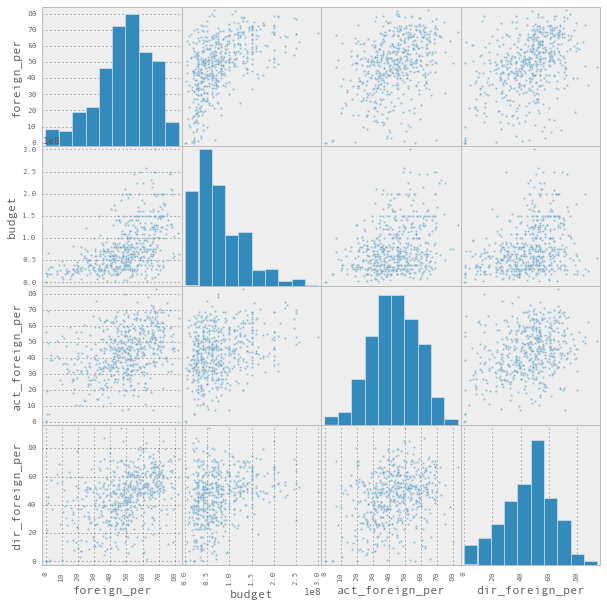

In [218]:
_ = pd.tools.plotting.scatter_matrix(movies_df3)

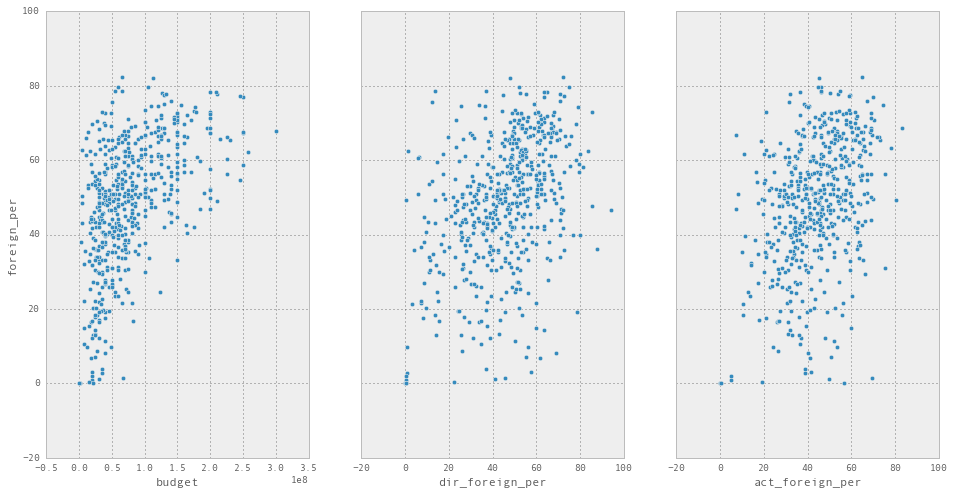

In [233]:
# visualize the relationship between the features and the response using scatterplots
plt.rcParams['figure.figsize'] = (10,8)
fig, axs = plt.subplots(1, 3, sharey=True)
movies_df3.plot(kind='scatter', x='budget', y='foreign_per', ax=axs[0], figsize=(16, 8))
movies_df3.plot(kind='scatter', x='dir_foreign_per', y='foreign_per', ax=axs[1])
movies_df3.plot(kind='scatter', x='act_foreign_per', y='foreign_per', ax=axs[2])

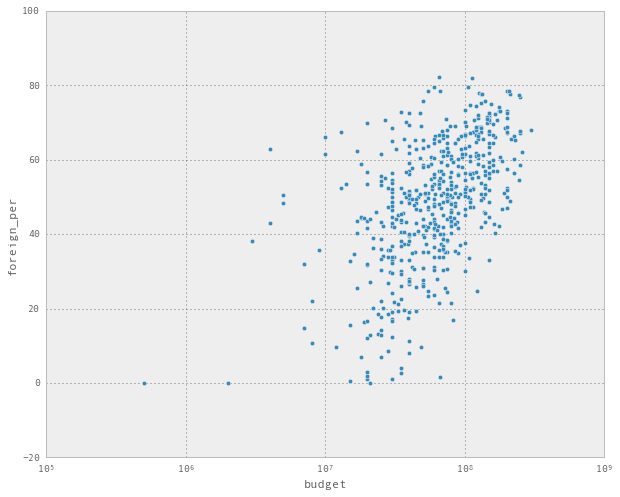

In [234]:
# visualize the relationship between the features and the response using scatterplots
plt.rcParams['figure.figsize'] = (10,8)

movies_df3.plot(kind='scatter', x='budget', y='foreign_per', logx = True)

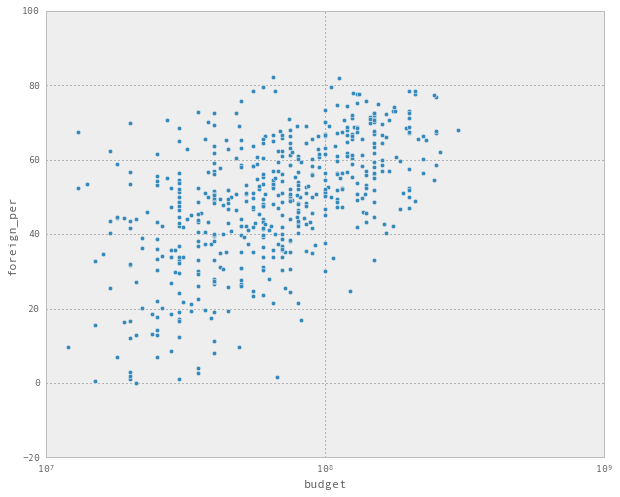

In [238]:
movies_df3 = movies_df3[movies_df3.budget > 10000000]

movies_df3.plot(kind='scatter', x='budget', y='foreign_per', logx = True)

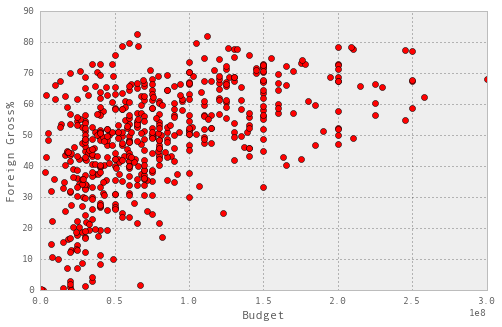

In [67]:
from matplotlib import pyplot as plt
# Try a transformation to log(budget)

plt.rcParams['figure.figsize'] = (8,5)

#first plot buget with log
plt.plot(movies_df3.budget, movies_df3.foreign_per, 'ro')
plt.xlabel('Budget')
plt.ylabel('Foreign Gross%')

In [256]:

# Try a transformation to log(budget)

movies_df3['log_budget']=np.log(movies_df3.budget)


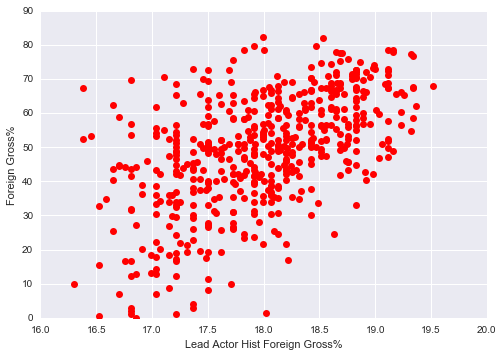

ValueError: x and y must have same first dimension

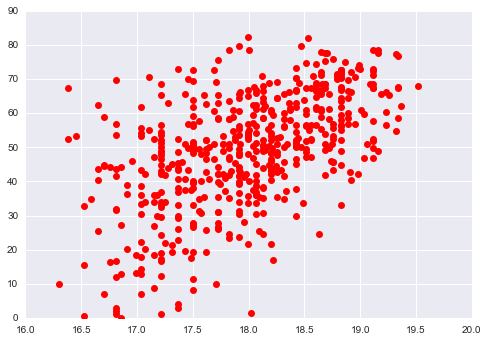

In [379]:
# get rid of outliers
movies_df3 = movies_df3[movies_df3.log_budget >16]

plt.plot(movies_df3.log_budget, movies_df3.foreign_per, 'ro')
plt.plot(movies_df3.log_budget, log_results.fittedvalues, 'b', type = 'line')
plt.xlabel('log(Budget)')
plt.ylabel('Foreign Gross%')

ValueError: x and y must have same first dimension

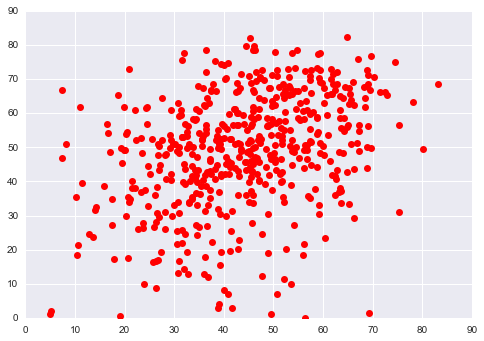

In [381]:
# get rid of outliers
movies_df3 = movies_df3[movies_df3.log_budget >16]

plt.plot(movies_df3.act_foreign_per, movies_df3.foreign_per, 'ro')
plt.plot(movies_df3.act_foreign_per, log_results.fittedvalues, 'b')
plt.xlabel('log(Budget)')
plt.ylabel('Foreign Gross%')

In [219]:
from patsy import dmatrices
import statsmodels.api as sm

In [382]:
y, X = dmatrices('foreign_per ~ log_budget + dir_foreign_per + act_foreign_per', 
                 data=movies_df3, return_type='dataframe')

In [383]:
model = sm.OLS(y, X)
results = model.fit()

In [384]:
X.head()

,Intercept,log_budget,dir_foreign_per,act_foreign_per
0,1.0,17.727534,51.300000,63.418182
1,1.0,17.034386,63.300000,31.977778
3,1.0,17.216708,53.966667,53.700000
7,1.0,18.197537,27.450000,22.100000
8,1.0,18.258162,44.400000,68.450000


In [385]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            foreign_per   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     113.1
Date:                Thu, 14 Jul 2016   Prob (F-statistic):           1.20e-56
Time:                        21:32:59   Log-Likelihood:                -2137.5
No. Observations:                 535   AIC:                             4283.
Df Residuals:                     531   BIC:                             4300.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        -168.3611     15.655    -10.754      0.000      -199.115  -137.607
log_budget         11.0773      0.906     12.233      0.000         9.298    12.856
dir_foreign_per     0.1956      0.035      5.646      0.000         0.128     0.264
act_foreign_per     0.2099      0.042      5.028      0.000         0.128     0.292
==============================================================================
Omnibus:                       11.937   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               13.784
Skew:                          -0.273   Prob(JB):                      0.00102
Kurtosis:                       3.566   Cond. No.                     1.88e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

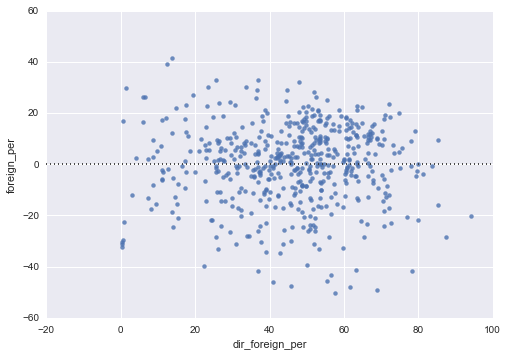

In [335]:
from seaborn import residplot

residplot(movies_df3.dir_foreign_per, movies_df3.foreign_per)

In [93]:
top_actors = movies_df2.sort_values('act_foreign_per', ascending = False)
top_dir = movies_df2.sort_values('dir_foreign_per', ascending = False)

In [94]:
top_actors = top_actors.drop_duplicates(['lead_actor'])
top_dir = top_dir.drop_duplicates(['lead_director'])

In [99]:
top_actors = top_actors.head(15)
top_dir = top_dir.head(15)

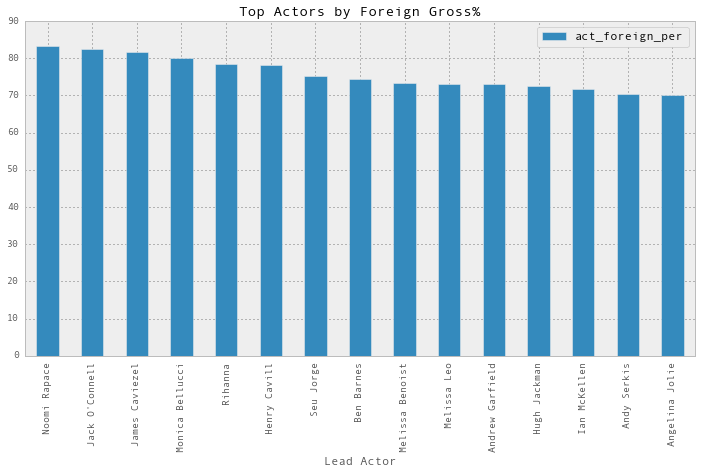

In [100]:
plt.rcParams['figure.figsize'] = (12, 6)
top_actors.plot(x = 'lead_actor', y = 'act_foreign_per', kind='bar')
plt.xlabel('Lead Actor')

#plt.ylabel('Foreign Gross%')
plt.title('Top Actors by Foreign Gross%')

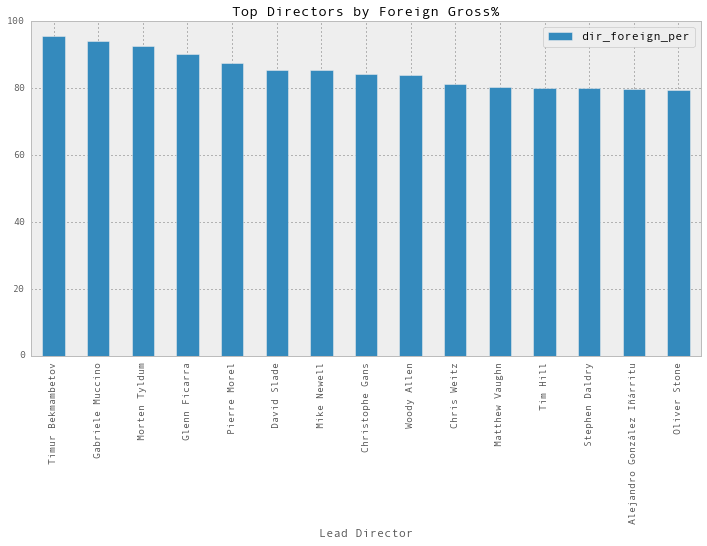

In [101]:
plt.rcParams['figure.figsize'] = (12, 6)
top_dir.plot(x = 'lead_director', y = 'dir_foreign_per', kind='bar')
plt.xlabel('Lead Director')
#plt.ylabel('Foreign Gross%')
plt.title('Top Directors by Foreign Gross%')

In [153]:
movies_df3.head()

,title,foreign_per,budget,act_foreign_per,dir_foreign_per,log_budget
0,Non-Stop,58.6,50000000.0,63.418182,51.300000,17.727534
1,The Gambler,14.3,25000000.0,31.977778,63.300000,17.034386
3,Sicario,44.7,30000000.0,53.700000,53.966667,17.216708
7,Evolution,61.0,80000000.0,22.100000,27.450000,18.197537
8,Memoirs of a Geisha,64.6,85000000.0,68.450000,44.400000,18.258162


In [393]:
y, X = dmatrices('foreign_per ~ log_budget + act_foreign_per + dir_foreign_per', 
                 data=movies_df3, return_type='dataframe')

In [394]:
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)

model = LinearRegression().fit(X_train, y_train)

In [395]:
X_train.shape

(401, 4)

In [396]:
model.score(X_train, y_train)

0.38635193141226781

In [397]:
model.score(X_test, y_test)

0.39512285259217994

In [398]:
# log_budget
from sklearn import metrics
metrics.mean_squared_error(y_train,model.predict(X_train))

173.48737596520058

In [399]:
metrics.mean_squared_error(y_test,model.predict(X_test))

172.2073370869939

In [293]:
from sklearn.cross_validation import KFold
kf = KFold(401, n_folds=5)

In [277]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    mse_log_budget=metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(mse_log_budget))

[[  0.          10.63277249   0.22138068   0.18335805]]
[[  0.          10.70598918   0.21365142   0.14647929]]
[[  0.          10.22161106   0.18142836   0.18712053]]
[[  0.          12.38643155   0.18112012   0.17115927]]
[[  0.          10.32424776   0.23332142   0.18000787]]
178.557800904


In [285]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    mse_budget = metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(mse_budget))

[[  0.00000000e+00   1.16152437e-07   2.12778839e-01   1.99147846e-01]]
[[  0.00000000e+00   1.27604090e-07   2.10699766e-01   1.47271839e-01]]
[[  0.00000000e+00   1.20784519e-07   1.63243218e-01   1.92182617e-01]]
[[  0.00000000e+00   1.39764575e-07   1.85056399e-01   1.82179376e-01]]
[[  0.00000000e+00   1.18000551e-07   2.33083416e-01   1.83815448e-01]]
194.991987293


In [266]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    act_log_budget = metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(act_log_budget))

[[  0.          11.70047953   0.2617352 ]]
[[  0.          11.61070484   0.25600603]]
[[  0.          11.22837995   0.23669159]]
[[  0.          13.32917695   0.2163635 ]]
[[  0.          11.11079572   0.28109438]]
186.282991475


In [294]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    dir_log_budget = metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(dir_log_budget))

[[  0.00000000e+00   1.28481301e-07   2.33032901e-01]]
[[  0.00000000e+00   1.36521946e-07   1.87475284e-01]]
[[  0.00000000e+00   1.29352193e-07   2.23757234e-01]]
[[  0.00000000e+00   1.50194381e-07   2.07397603e-01]]
[[  0.00000000e+00   1.31132714e-07   2.29761473e-01]]
190.510345461


In [303]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    mpaa_log_budget = metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(mpaa_log_budget))

[[  0.           6.35066321   5.91840263   7.63488306  11.90009272
    0.21697123]]
[[  0.           6.98860903   7.57558341   7.54675843  11.42225767
    0.18907811]]
[[  0.           7.03755684   7.4209428    9.06527215  11.18250097
    0.22223402]]
[[  0.           6.77403799   7.34236167   9.80587918  13.79087
    0.19588755]]
[[  0.           6.4928665    8.09756144  10.9329691   12.08191505
    0.22637181]]
184.760498019


In [368]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    inter = metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(inter))

[[  0.00000000e+00   1.05501031e+01   7.60146145e-02   1.11511856e-01
    2.43511779e-03]]
[[  0.00000000e+00   1.06812276e+01   5.87089931e-02   1.26631954e-01
    2.01753343e-03]]
[[  0.00000000e+00   1.01377115e+01   9.84761141e-02   8.51488529e-02
    2.12059025e-03]]
[[  0.00000000e+00   1.23630896e+01   1.07852844e-01   1.18150065e-01
    1.48648359e-03]]
[[  0.00000000e+00   1.03137193e+01   2.16022830e-01   2.71479503e-01
   -8.35644730e-04]]
179.930556429


In [371]:
for train_index, test_index in kf:
    #X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    #y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    ## Fit on Train! 
    clf2 = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    # Score on Test! 
    print(clf2.coef_)
    inter_only = metrics.mean_squared_error(y.iloc[test_index], clf2.predict(X.iloc[test_index]))
print(np.mean(inter_only))

[[  0.00000000e+00   1.05501031e+01   1.11511856e-01   7.60146145e-02
    2.43511779e-03]]
[[  0.00000000e+00   1.06812276e+01   1.26631954e-01   5.87089931e-02
    2.01753343e-03]]
[[  0.00000000e+00   1.01377115e+01   8.51488529e-02   9.84761141e-02
    2.12059025e-03]]
[[  0.00000000e+00   1.23630896e+01   1.18150065e-01   1.07852844e-01
    1.48648359e-03]]
[[  0.00000000e+00   1.03137193e+01   2.71479503e-01   2.16022830e-01
   -8.35644730e-04]]
179.930556429


In [318]:
from sklearn.preprocessing import normalize

norm_X = normalize(X_train, axis = 0)

In [401]:
# check with ridge regression
from sklearn import linear_model
clf = linear_model.RidgeCV(alphas=[0, 0.05, 0.1, 1.0, 2.5, 5.0, 10.0])
clf.fit(norm_X, y_train)       

print(clf.alpha_)


0.0


In [312]:
import scipy
from scipy.stats import pearsonr

pearsonr(movies_df3.act_foreign_per, movies_df3.dir_foreign_per)

(0.26795849274829392, 2.9966530798795042e-10)

In [313]:
pearsonr(movies_df3.dir_foreign_per, movies_df3.budget)

(0.30312586181658241, 7.826468796377001e-13)

In [314]:
pearsonr(movies_df3.act_foreign_per, movies_df3.budget)

(0.28946090814391517, 8.71553374153154e-12)

References: 
- Documentation on finding elements:
- http://selenium-python.readthedocs.org/en/latest/locating-elements.html
- Xpath tutorial:
-  http://www.w3schools.com/xpath/xpath_syntax.asp